# 4 - LSTM Model Training Notebook 

In [1]:
import sys  
sys.path.insert(1, '/Users/simon/Documents/II/Dissertation/src')
import pandas as pd
import misc

%load_ext autoreload
%autoreload 2

Load the data

In [2]:
df = misc.load_processed_dataset("aapl", "2018-01-01", "2023-01-1")
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Close Forecast', 'Close_T-1', 'Close_T-2', 'Close_T-5', 'SMA_10',
       'SMA_20', 'SMA_50', 'EMA_10', 'EMA_20', 'EMA_50', 'RSI_14',
       'upper_band', 'middle_band', 'lower_band', 'macd', 'macdsignal',
       'macdhist', 'OBV', 'ADX', 'AD', 'Aroon_down', 'Aroon_up', 'SlowK',
       'SlowD', 'Williams %R', 'pct_change', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'S&P Close'],
      dtype='object')

Feature selection

In [41]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Close Forecast', 'SMA_10',
       'SMA_20', 'SMA_50', 'EMA_10', 'EMA_20', 'EMA_50', 'RSI_14',
       'upper_band', 'middle_band', 'lower_band', 'macd', 'macdsignal',
       'macdhist', 'OBV', 'ADX', 'AD', 'Aroon_down', 'Aroon_up', 'SlowK',
       'SlowD', 'Williams %R', 'pct_change', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'S&P Close']
features = ['Open', 'High', 'Low', 'Close', 'Volume']
Xs = df[features]
ys = df["Close Forecast"]

Normalisation

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xs_scaled = scaler.fit_transform(Xs.values)
ys_scaled = scaler.fit_transform(ys.values.reshape(-1,1))
Xs_scaled.shape, ys_scaled.shape

((1259, 5), (1259, 1))

Create sequences

In [49]:
import numpy as np

def create_sequences(timeseries, sequence_length):
    """
    Given a numpy array, create sequences of a fixed length, where
    each sequence will be used to predict the closing price of the next day.
    """
    output = []
    for i in range(len(timeseries)-sequence_length-1):
        sequence = timeseries[i:(i + sequence_length)]
        output.append(sequence)
    return np.array(output)

In [50]:
WINDOW_SIZE = 60
X = create_sequences(Xs_scaled, WINDOW_SIZE)
y = create_sequences(ys_scaled, WINDOW_SIZE)
X.shape, y.shape

((1198, 60, 5), (1198, 60, 1))

In [51]:
X[0][0]

array([-1.20690492, -1.20576904, -1.20311154, -1.19735647, -0.26638045])

Dataset splitting

In [22]:
X_train, X_test, y_train, y_test = misc.create_train_test_set(df, 0.8, verbose=False)

In [ ]:
Xs = df

In [23]:
Xs = pd.concat([X_train, X_test])
ys = pd.concat([y_train, y_test])


In [35]:
WINDOW_SIZE = 60
Xs_train = create_sequences(Xs_scaled, WINDOW_SIZE)
ys_train = create_sequences(ys_scaled, WINDOW_SIZE)
Xs_train.shape, ys_train.shape

((1198, 60, 5), (1198, 60, 1))

In [37]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(Xs_train.astype(np.float32))
y_train_tensor = torch.tensor(ys_train.astype(np.float32))
# X_test_tensor = torch.tensor(X_test.astype(np.float32))
# y_test_tensor = torch.tensor(y_test.astype(np.float32))

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Model definition

In [6]:
import torch
import torch.nn as nn

class StockPriceLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(StockPriceLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [7]:
input_dim = 5  # Number of features
hidden_dim = 64  # Number of features in hidden state
num_layers = 2  # Number of stacked LSTM layers
output_dim = 1  # Number of output classes (predicting 'Close Forecast')

model = StockPriceLSTM(input_dim, hidden_dim, num_layers, output_dim)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [12]:
Xs

,Open,High,Low,Close,Volume
Date,,,,,
2018-01-02 05:00:00,40.175158,40.680417,39.962664,40.670971,102223600
2018-01-03 05:00:00,40.734722,41.211650,40.600146,40.663891,118071600
2018-01-04 05:00:00,40.737080,40.956657,40.628475,40.852772,89738400
2018-01-05 05:00:00,40.949571,41.405247,40.857492,41.317890,94640000
2018-01-08 05:00:00,41.164429,41.461916,41.065263,41.164429,82271200
...,...,...,...,...,...
2022-12-23 05:00:00,130.026375,131.516136,128.755113,130.959961,63814900
2022-12-27 05:00:00,130.483247,130.513041,127.841400,129.142456,69007800
2022-12-28 05:00:00,128.784900,130.135617,125.010842,125.179680,85438400


In [23]:
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)
y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float)
y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float)

# Create TensorDatasets
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [29]:
num_epochs = 20  # Number of epochs

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        print(inputs.shape)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))  # Make sure labels are the correct shape
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


torch.Size([64, 5])


RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

In [25]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Inference without calculating gradients
    predictions = []
    actuals = []
    for inputs, labels in test_loader:
        output = model(inputs)
        predictions.extend(output.view(-1).tolist())
        actuals.extend(labels.tolist())
    
# Compute RMSE or other relevant metrics
# Note: You'd typically rescale predictions and actuals back to their original scale if you normalized your data


RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

/var/folders/d7/ktx3dym91yjgj_gpmnfs0rh00000gn/T/ipykernel_56212/1809956353.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Ys_train.append(Ys[i-1])


((948, 60, 5), (948,))

Model predictions

In [ ]:
preds = model(X_test)

Visualisation

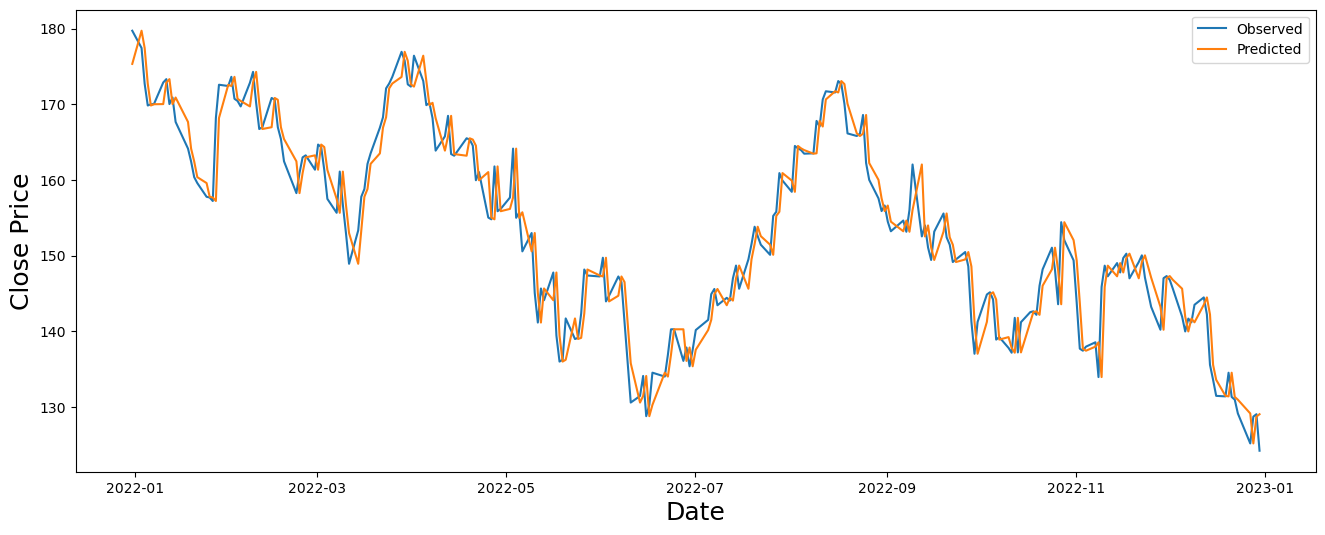

In [ ]:
misc.plot(preds, Y_test)

Evaluate

In [ ]:
misc.evaluate(preds, Y_test, verbose=True)

R^2: 0.9303330122839852
MSE: 11.482614162149341
RMSE: 3.3886006200420464
MAE: 2.6411944192553323
MAPE: 1.7461289574429155


(0.9303330122839852,
 11.482614162149341,
 3.3886006200420464,
 2.6411944192553323,
 1.7461289574429155)